In [0]:
%tensorflow_version 1.x
import tensorflow
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

seed = 42
np.random.seed(seed)
% matplotlib inline

TensorFlow 1.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir('/content')
from google.colab import files
keys = files.upload()

Saving ssh.tar.gz to ssh.tar.gz


In [0]:
!rm -rf /root/.ssh
!mkdir /root/.ssh

!tar xvzf ssh.tar.gz

!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab
!chmod 700 /root/.ssh

!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts

ssh-colab/
ssh-colab/config
ssh-colab/id_rsa_colab
ssh-colab/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-72deb3a2
# github.com:22 SSH-2.0-babeld-72deb3a2
# github.com:22 SSH-2.0-babeld-72deb3a2


In [0]:
!ssh-agent /bin/bash

bash: cannot set terminal process group (144): Inappropriate ioctl for device
bash: no job control in this shell
]0;root@4c6b5f96849c: /contentroot@4c6b5f96849c:/content# ssh-add /root/.ssh/id_rsa_colab
Identity added: /root/.ssh/id_rsa_colab (/root/.ssh/id_rsa_colab)
]0;root@4c6b5f96849c: /contentroot@4c6b5f96849c:/content# ssh-add -l
2048 SHA256:SpU/DuMOwLsZmS9hdQfImWud0o5YhuYTkxLgNOtF1aA /root/.ssh/id_rsa_colab (RSA)
]0;root@4c6b5f96849c: /contentroot@4c6b5f96849c:/content# exit
exit


In [0]:
!git config --global user.email 'rashmi.raviprasad@gmail.com'
!git config --global user.name 'rashmi-raviprasad'

In [0]:
IMAGE_DIRECTORY = '/content/drive/My Drive/Springboard DS Course/CAPSTONE 2/IMAGES/NEW_FINAL_PICS'
REPOSITORY = '/content/drive/My Drive/Springboard DS Course/REPOSITORY/springboard'
os.chdir(REPOSITORY+'/faces_capstone2')

In [0]:
from keras.models import Sequential

class Decoder(Sequential):
  def load_data(self, cat_dir, face_dir, n_images=1000):
    self.imgs = []
    cat_samples = np.random.choice(cat_dir, int(n_images/2), replace=False)
    face_samples = np.random.choice(face_dir, int(n_images/2), replace=False)
    all_samples = np.concatenate((cat_samples, face_samples))
    try:
      for file in tqdm(all_samples):
        fn = IMAGE_DIRECTORY + '/' + file
        img = cv2.imread(fn)
        rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.imgs.append(rgb_image.astype(np.float32) / 255.)
    except:
      print(file)
    np.random.shuffle(self.imgs)
    x_all = np.arange(len(self.imgs))
    self.all_dim = np.asarray(self.imgs).shape[0]
    X = np.array(x_all)
    y = np.array(self.imgs)
    self.X = X
    self.y = y
    return X, y
  def build_model(self, n_components, model_filename, log_filename, n_dim=1000, decoder=None):
    os.chdir(REPOSITORY+'/faces_capstone2')
    decoder = Sequential()
    decoder.add(Embedding(input_dim=n_dim, output_dim=n_components, input_length=1))
    decoder.add(Flatten())
    decoder.add(Reshape((1, 1, n_components)))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, activation='sigmoid'))
    decoder.compile(optimizer='adam', loss='mse')
    self.model_filename = model_filename
    decoder.save(self.model_filename)
    self.decoder = decoder
    self.log_filename = log_filename
    train_log = pd.DataFrame(columns=['Date', 'Run_Number', 'Num_Epochs_Tot', 
                                      'Train_Loss', 'Valid_Loss'])
    init_data = {'Date':datetime.now(), 'Run_Number':0, 'Num_Epochs_Tot':0, 'Train_Loss':None, 
                 'Valid_Loss':None}
    train_log.loc[len(train_log)] = list(init_data.values())
    train_log.to_csv(self.log_filename, index=False)
  def fit_model(self, X, y, i, model_filename, log_filename, batch_size, n_epochs, tot_epochs):
    os.chdir(REPOSITORY+'/faces_capstone2')
    model = load_model(model_filename)
    model_hist = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
    model.save(model_filename)
    train_log = pd.read_csv(log_filename)
    #current_epoch = train_log['Num_Epochs_Tot'].iloc[-1]
    #self.batch_num = train_log['Run_Number'].iloc[-1]
    data_dict = {'Date':datetime.now(), 'Run_Number':(i+1), 'Num_Epochs_Tot':n_epochs*(i+1), 
                 'Train_Loss':model_hist.history['loss'][-1], 'Valid_Loss':model_hist.history['val_loss'][-1]}
    train_log.loc[len(train_log)] = list(data_dict.values())
    train_log.to_csv(log_filename, index=False)
    #self.epochs_remaining = tot_epochs - current_epoch
  def predict_model(self, X, y, model_filename, batch_size):
    os.chdir(REPOSITORY+'/faces_capstone2')
    self.decoder = load_model(model_filename)
    return self.decoder.predict(X, batch_size=batch_size)

Using TensorFlow backend.


In [0]:
def save_to_git(commit_msg):
  os.chdir(REPOSITORY)
  os.environ['MSG'] = commit_msg
  !git pull
  !git add .
  !git commit -m $MSG
  !git push

In [0]:
decoder_model = Decoder()
#decoder_model.load_data()

img_list = os.listdir(IMAGE_DIRECTORY)
cat_dir = []
face_dir = []
for filename in tqdm(img_list):
  if '_' in filename:
    cat_dir.append(filename)
  else:
    face_dir.append(filename)

100%|██████████| 56709/56709 [00:00<00:00, 1832965.63it/s]


In [0]:
#from keras.models import Sequential
from keras.layers import Activation, Input, Flatten, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.embeddings import Embedding
from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_data_format('channels_last')
K.clear_session()

In [0]:
BATCH_SIZE = 32 #make it like 32 or 64 or something
N_COMPONENTS = 100
MODEL_FN = 'decoder.h5'
LOGS_FN = 'train_log.csv'
N_EPOCHS = 20
N_IMAGES = 500

#decoder_model.build_model(N_COMPONENTS, MODEL_FN, LOGS_FN, n_dim=N_IMAGES)

In [0]:
from keras.models import load_model

#codeparade had 1769 images, augmented them to make 35,380 samples.
#he used 2000 epochs, so tot num of imgs seen by his network was 70,760,000.
#I am using pulls of 500 imgs and 20 epochs per pull. In order to
#match num of imgs seen by my network to his, I need to pull from the 
#dataset 7,076 times.

N_PULLS = 7076
N_TOT_EPOCHS = N_EPOCHS * N_PULLS
N_EPOCHS_REMAINING = N_TOT_EPOCHS
while N_EPOCHS_REMAINING > 0:
  log = pd.read_csv(LOGS_FN)
  i = 461
  print('Loading %d images' % N_IMAGES)
  X, y = decoder_model.load_data(cat_dir, face_dir, n_images=N_IMAGES)
  print('Training Batch # %d' % (i+1))
  decoder_model.fit_model(X, y, i, MODEL_FN, LOGS_FN, BATCH_SIZE, N_EPOCHS, N_TOT_EPOCHS)
  message = 'trained %d of %d epochs' % (N_EPOCHS*(i+1), N_TOT_EPOCHS)
  message = message.replace(' ', '_')
  if (i+1) % 25 == 0:
    save_to_git(message)
  print('Trained %d epochs for total of %d epochs' % (N_EPOCHS, N_EPOCHS*(i+1)))
  N_EPOCHS_REMAINING = N_TOT_EPOCHS - N_EPOCHS*(i+1)
  i += 1

  0%|          | 0/500 [00:00<?, ?it/s]

Loading 500 images


100%|██████████| 500/500 [02:32<00:00,  3.27it/s]


Training Batch # 462











Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0729 - val_loss: 0.0793
Epoch 2/20
400/400 [==============================] - 0s 906us/step - loss: 0.0670 - val_loss: 0.0730
Epoch 3/20
400/400 [==============================] - 0s 869us/step - loss: 0.0653 - val_loss: 0.0729
Epoch 4/20
400/400 [==============================] - 0s 850us/step - loss: 0.0639 - val_loss: 0.0735
Epoch 5/20
400/400 [==============================] - 0s 879us/step - loss: 0.0633 - val_loss: 0.0742
Epoch 6/20
400/400 [==============================] - 0s 852us/step - loss: 0.0625 - val_loss: 0.0746
Epoch 7/20
400/400 [==============================] - 0s 837us/step - loss: 0.0618 - val_loss: 0.0756
Epoch 8/20
400/400 [==============================] - 0s 871us/step - loss: 0.0611 - val_loss: 0.0761
Epoch 9/20
400/400 [==============================] - 0s 878us/step - loss: 0.0606 - val_loss: 0.0765
Epoch

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:25<00:00,  3.44it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0717 - val_loss: 0.0774
Epoch 2/20
400/400 [==============================] - 0s 880us/step - loss: 0.0659 - val_loss: 0.0730
Epoch 3/20
400/400 [==============================] - 0s 879us/step - loss: 0.0639 - val_loss: 0.0732
Epoch 4/20
400/400 [==============================] - 0s 893us/step - loss: 0.0627 - val_loss: 0.0734
Epoch 5/20
400/400 [==============================] - 0s 882us/step - loss: 0.0618 - val_loss: 0.0735
Epoch 6/20
400/400 [==============================] - 0s 906us/step - loss: 0.0611 - val_loss: 0.0740
Epoch 7/20
400/400 [==============================] - 0s 898us/step - loss: 0.0604 - val_loss: 0.0763
Epoch 8/20
400/400 [==============================] - 0s 898us/step - loss: 0.0599 - val_loss: 0.0765
Epoch 9/20
400/400 [==============================] - 0s 913us/step - loss: 0.0592 - val_loss: 0.0773
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:40<00:00,  3.11it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0708 - val_loss: 0.0771
Epoch 2/20
400/400 [==============================] - 0s 906us/step - loss: 0.0658 - val_loss: 0.0734
Epoch 3/20
400/400 [==============================] - 0s 901us/step - loss: 0.0636 - val_loss: 0.0734
Epoch 4/20
400/400 [==============================] - 0s 924us/step - loss: 0.0624 - val_loss: 0.0733
Epoch 5/20
400/400 [==============================] - 0s 918us/step - loss: 0.0616 - val_loss: 0.0740
Epoch 6/20
400/400 [==============================] - 0s 910us/step - loss: 0.0609 - val_loss: 0.0747
Epoch 7/20
400/400 [==============================] - 0s 902us/step - loss: 0.0602 - val_loss: 0.0753
Epoch 8/20
400/400 [==============================] - 0s 897us/step - loss: 0.0596 - val_loss: 0.0764
Epoch 9/20
400/400 [==============================] - 0s 920us/step - loss: 0.0591 - val_loss: 0.0773
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:27<00:00,  3.39it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0760 - val_loss: 0.0849
Epoch 2/20
400/400 [==============================] - 0s 929us/step - loss: 0.0703 - val_loss: 0.0796
Epoch 3/20
400/400 [==============================] - 0s 925us/step - loss: 0.0679 - val_loss: 0.0780
Epoch 4/20
400/400 [==============================] - 0s 911us/step - loss: 0.0669 - val_loss: 0.0781
Epoch 5/20
400/400 [==============================] - 0s 914us/step - loss: 0.0660 - val_loss: 0.0781
Epoch 6/20
400/400 [==============================] - 0s 903us/step - loss: 0.0653 - val_loss: 0.0784
Epoch 7/20
400/400 [==============================] - 0s 908us/step - loss: 0.0646 - val_loss: 0.0797
Epoch 8/20
400/400 [==============================] - 0s 915us/step - loss: 0.0641 - val_loss: 0.0809
Epoch 9/20
400/400 [==============================] - 0s 910us/step - loss: 0.0635 - val_loss: 0.0814
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:18<00:00,  3.60it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0742 - val_loss: 0.0800
Epoch 2/20
400/400 [==============================] - 0s 878us/step - loss: 0.0692 - val_loss: 0.0725
Epoch 3/20
400/400 [==============================] - 0s 868us/step - loss: 0.0669 - val_loss: 0.0732
Epoch 4/20
400/400 [==============================] - 0s 881us/step - loss: 0.0658 - val_loss: 0.0736
Epoch 5/20
400/400 [==============================] - 0s 861us/step - loss: 0.0650 - val_loss: 0.0744
Epoch 6/20
400/400 [==============================] - 0s 855us/step - loss: 0.0643 - val_loss: 0.0749
Epoch 7/20
400/400 [==============================] - 0s 901us/step - loss: 0.0637 - val_loss: 0.0754
Epoch 8/20
400/400 [==============================] - 0s 870us/step - loss: 0.0631 - val_loss: 0.0767
Epoch 9/20
400/400 [==============================] - 0s 861us/step - loss: 0.0626 - val_loss: 0.0768
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:32<00:00,  3.29it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0726 - val_loss: 0.0768
Epoch 2/20
400/400 [==============================] - 0s 927us/step - loss: 0.0671 - val_loss: 0.0738
Epoch 3/20
400/400 [==============================] - 0s 909us/step - loss: 0.0654 - val_loss: 0.0731
Epoch 4/20
400/400 [==============================] - 0s 907us/step - loss: 0.0644 - val_loss: 0.0729
Epoch 5/20
400/400 [==============================] - 0s 939us/step - loss: 0.0637 - val_loss: 0.0737
Epoch 6/20
400/400 [==============================] - 0s 927us/step - loss: 0.0630 - val_loss: 0.0742
Epoch 7/20
400/400 [==============================] - 0s 915us/step - loss: 0.0624 - val_loss: 0.0747
Epoch 8/20
400/400 [==============================] - 0s 918us/step - loss: 0.0619 - val_loss: 0.0753
Epoch 9/20
400/400 [==============================] - 0s 930us/step - loss: 0.0612 - val_loss: 0.0762
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:18<00:00,  3.60it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0698 - val_loss: 0.0802
Epoch 2/20
400/400 [==============================] - 0s 912us/step - loss: 0.0655 - val_loss: 0.0746
Epoch 3/20
400/400 [==============================] - 0s 887us/step - loss: 0.0637 - val_loss: 0.0751
Epoch 4/20
400/400 [==============================] - 0s 906us/step - loss: 0.0626 - val_loss: 0.0745
Epoch 5/20
400/400 [==============================] - 0s 924us/step - loss: 0.0619 - val_loss: 0.0749
Epoch 6/20
400/400 [==============================] - 0s 913us/step - loss: 0.0613 - val_loss: 0.0758
Epoch 7/20
400/400 [==============================] - 0s 911us/step - loss: 0.0606 - val_loss: 0.0764
Epoch 8/20
400/400 [==============================] - 0s 937us/step - loss: 0.0602 - val_loss: 0.0765
Epoch 9/20
400/400 [==============================] - 0s 950us/step - loss: 0.0595 - val_loss: 0.0771
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:21<00:00,  3.54it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0735 - val_loss: 0.0790
Epoch 2/20
400/400 [==============================] - 0s 935us/step - loss: 0.0676 - val_loss: 0.0737
Epoch 3/20
400/400 [==============================] - 0s 950us/step - loss: 0.0652 - val_loss: 0.0727
Epoch 4/20
400/400 [==============================] - 0s 937us/step - loss: 0.0641 - val_loss: 0.0728
Epoch 5/20
400/400 [==============================] - 0s 936us/step - loss: 0.0632 - val_loss: 0.0733
Epoch 6/20
400/400 [==============================] - 0s 951us/step - loss: 0.0626 - val_loss: 0.0740
Epoch 7/20
400/400 [==============================] - 0s 937us/step - loss: 0.0619 - val_loss: 0.0741
Epoch 8/20
400/400 [==============================] - 0s 942us/step - loss: 0.0612 - val_loss: 0.0746
Epoch 9/20
400/400 [==============================] - 0s 943us/step - loss: 0.0605 - val_loss: 0.0751
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:10<00:00,  3.83it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0720 - val_loss: 0.0733
Epoch 2/20
400/400 [==============================] - 0s 869us/step - loss: 0.0666 - val_loss: 0.0708
Epoch 3/20
400/400 [==============================] - 0s 891us/step - loss: 0.0644 - val_loss: 0.0707
Epoch 4/20
400/400 [==============================] - 0s 876us/step - loss: 0.0635 - val_loss: 0.0703
Epoch 5/20
400/400 [==============================] - 0s 884us/step - loss: 0.0628 - val_loss: 0.0707
Epoch 6/20
400/400 [==============================] - 0s 892us/step - loss: 0.0621 - val_loss: 0.0708
Epoch 7/20
400/400 [==============================] - 0s 892us/step - loss: 0.0612 - val_loss: 0.0713
Epoch 8/20
400/400 [==============================] - 0s 891us/step - loss: 0.0606 - val_loss: 0.0720
Epoch 9/20
400/400 [==============================] - 0s 881us/step - loss: 0.0601 - val_loss: 0.0727
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:14<00:00,  3.73it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0750 - val_loss: 0.0764
Epoch 2/20
400/400 [==============================] - 0s 892us/step - loss: 0.0688 - val_loss: 0.0707
Epoch 3/20
400/400 [==============================] - 0s 904us/step - loss: 0.0666 - val_loss: 0.0705
Epoch 4/20
400/400 [==============================] - 0s 913us/step - loss: 0.0654 - val_loss: 0.0702
Epoch 5/20
400/400 [==============================] - 0s 897us/step - loss: 0.0645 - val_loss: 0.0709
Epoch 6/20
400/400 [==============================] - 0s 904us/step - loss: 0.0637 - val_loss: 0.0711
Epoch 7/20
400/400 [==============================] - 0s 918us/step - loss: 0.0630 - val_loss: 0.0718
Epoch 8/20
400/400 [==============================] - 0s 898us/step - loss: 0.0624 - val_loss: 0.0723
Epoch 9/20
400/400 [==============================] - 0s 912us/step - loss: 0.0619 - val_loss: 0.0725
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:03<00:00,  4.05it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0735 - val_loss: 0.0771
Epoch 2/20
400/400 [==============================] - 0s 876us/step - loss: 0.0675 - val_loss: 0.0745
Epoch 3/20
400/400 [==============================] - 0s 913us/step - loss: 0.0652 - val_loss: 0.0742
Epoch 4/20
400/400 [==============================] - 0s 912us/step - loss: 0.0640 - val_loss: 0.0747
Epoch 5/20
400/400 [==============================] - 0s 881us/step - loss: 0.0629 - val_loss: 0.0746
Epoch 6/20
400/400 [==============================] - 0s 910us/step - loss: 0.0623 - val_loss: 0.0760
Epoch 7/20
400/400 [==============================] - 0s 926us/step - loss: 0.0614 - val_loss: 0.0760
Epoch 8/20
400/400 [==============================] - 0s 934us/step - loss: 0.0608 - val_loss: 0.0764
Epoch 9/20
400/400 [==============================] - 0s 910us/step - loss: 0.0601 - val_loss: 0.0776
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Loading 500 images


100%|██████████| 500/500 [02:02<00:00,  4.07it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0736 - val_loss: 0.0724
Epoch 2/20
400/400 [==============================] - 0s 896us/step - loss: 0.0671 - val_loss: 0.0688
Epoch 3/20
400/400 [==============================] - 0s 880us/step - loss: 0.0649 - val_loss: 0.0680
Epoch 4/20
400/400 [==============================] - 0s 892us/step - loss: 0.0639 - val_loss: 0.0685
Epoch 5/20
400/400 [==============================] - 0s 900us/step - loss: 0.0631 - val_loss: 0.0688
Epoch 6/20
400/400 [==============================] - 0s 896us/step - loss: 0.0623 - val_loss: 0.0695
Epoch 7/20
400/400 [==============================] - 0s 911us/step - loss: 0.0617 - val_loss: 0.0701
Epoch 8/20
400/400 [==============================] - 0s 891us/step - loss: 0.0612 - val_loss: 0.0710
Epoch 9/20
400/400 [==============================] - 0s 886us/step - loss: 0.0604 - val_loss: 0.0720
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:55<00:00,  4.34it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0689 - val_loss: 0.0801
Epoch 2/20
400/400 [==============================] - 0s 912us/step - loss: 0.0635 - val_loss: 0.0759
Epoch 3/20
400/400 [==============================] - 0s 883us/step - loss: 0.0612 - val_loss: 0.0747
Epoch 4/20
400/400 [==============================] - 0s 895us/step - loss: 0.0603 - val_loss: 0.0750
Epoch 5/20
400/400 [==============================] - 0s 917us/step - loss: 0.0596 - val_loss: 0.0758
Epoch 6/20
400/400 [==============================] - 0s 906us/step - loss: 0.0590 - val_loss: 0.0754
Epoch 7/20
400/400 [==============================] - 0s 880us/step - loss: 0.0584 - val_loss: 0.0754
Epoch 8/20
400/400 [==============================] - 0s 902us/step - loss: 0.0578 - val_loss: 0.0771
Epoch 9/20
400/400 [==============================] - 0s 902us/step - loss: 0.0573 - val_loss: 0.0769
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:55<00:00,  4.32it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0726 - val_loss: 0.0738
Epoch 2/20
400/400 [==============================] - 0s 908us/step - loss: 0.0667 - val_loss: 0.0693
Epoch 3/20
400/400 [==============================] - 0s 885us/step - loss: 0.0645 - val_loss: 0.0692
Epoch 4/20
400/400 [==============================] - 0s 908us/step - loss: 0.0634 - val_loss: 0.0694
Epoch 5/20
400/400 [==============================] - 0s 890us/step - loss: 0.0627 - val_loss: 0.0697
Epoch 6/20
400/400 [==============================] - 0s 903us/step - loss: 0.0622 - val_loss: 0.0701
Epoch 7/20
400/400 [==============================] - 0s 914us/step - loss: 0.0617 - val_loss: 0.0707
Epoch 8/20
400/400 [==============================] - 0s 883us/step - loss: 0.0612 - val_loss: 0.0714
Epoch 9/20
400/400 [==============================] - 0s 860us/step - loss: 0.0608 - val_loss: 0.0718
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0733 - val_loss: 0.0809
Epoch 2/20
400/400 [==============================] - 0s 908us/step - loss: 0.0681 - val_loss: 0.0751
Epoch 3/20
400/400 [==============================] - 0s 870us/step - loss: 0.0660 - val_loss: 0.0757
Epoch 4/20
400/400 [==============================] - 0s 895us/step - loss: 0.0649 - val_loss: 0.0760
Epoch 5/20
400/400 [==============================] - 0s 913us/step - loss: 0.0640 - val_loss: 0.0764
Epoch 6/20
400/400 [==============================] - 0s 894us/step - loss: 0.0633 - val_loss: 0.0777
Epoch 7/20
400/400 [==============================] - 0s 891us/step - loss: 0.0628 - val_loss: 0.0798
Epoch 8/20
400/400 [==============================] - 0s 901us/step - loss: 0.0623 - val_loss: 0.0787
Epoch 9/20
400/400 [==============================] - 0s 914us/step - loss: 0.0616 - val_loss: 0.0795
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0716 - val_loss: 0.0767
Epoch 2/20
400/400 [==============================] - 0s 923us/step - loss: 0.0667 - val_loss: 0.0745
Epoch 3/20
400/400 [==============================] - 0s 891us/step - loss: 0.0645 - val_loss: 0.0734
Epoch 4/20
400/400 [==============================] - 0s 899us/step - loss: 0.0636 - val_loss: 0.0732
Epoch 5/20
400/400 [==============================] - 0s 887us/step - loss: 0.0625 - val_loss: 0.0738
Epoch 6/20
400/400 [==============================] - 0s 898us/step - loss: 0.0617 - val_loss: 0.0740
Epoch 7/20
400/400 [==============================] - 0s 900us/step - loss: 0.0610 - val_loss: 0.0750
Epoch 8/20
400/400 [==============================] - 0s 896us/step - loss: 0.0603 - val_loss: 0.0755
Epoch 9/20
400/400 [==============================] - 0s 899us/step - loss: 0.0597 - val_loss: 0.0764
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:51<00:00,  4.50it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0714 - val_loss: 0.0753
Epoch 2/20
400/400 [==============================] - 0s 891us/step - loss: 0.0649 - val_loss: 0.0703
Epoch 3/20
400/400 [==============================] - 0s 902us/step - loss: 0.0629 - val_loss: 0.0696
Epoch 4/20
400/400 [==============================] - 0s 874us/step - loss: 0.0618 - val_loss: 0.0700
Epoch 5/20
400/400 [==============================] - 0s 878us/step - loss: 0.0609 - val_loss: 0.0707
Epoch 6/20
400/400 [==============================] - 0s 888us/step - loss: 0.0601 - val_loss: 0.0715
Epoch 7/20
400/400 [==============================] - 0s 896us/step - loss: 0.0597 - val_loss: 0.0725
Epoch 8/20
400/400 [==============================] - 0s 898us/step - loss: 0.0591 - val_loss: 0.0733
Epoch 9/20
400/400 [==============================] - 0s 882us/step - loss: 0.0584 - val_loss: 0.0742
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:00<00:00,  4.13it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0727 - val_loss: 0.0744
Epoch 2/20
400/400 [==============================] - 0s 889us/step - loss: 0.0669 - val_loss: 0.0706
Epoch 3/20
400/400 [==============================] - 0s 903us/step - loss: 0.0646 - val_loss: 0.0700
Epoch 4/20
400/400 [==============================] - 0s 922us/step - loss: 0.0635 - val_loss: 0.0696
Epoch 5/20
400/400 [==============================] - 0s 904us/step - loss: 0.0627 - val_loss: 0.0698
Epoch 6/20
400/400 [==============================] - 0s 885us/step - loss: 0.0621 - val_loss: 0.0704
Epoch 7/20
400/400 [==============================] - 0s 911us/step - loss: 0.0614 - val_loss: 0.0709
Epoch 8/20
400/400 [==============================] - 0s 882us/step - loss: 0.0609 - val_loss: 0.0713
Epoch 9/20
400/400 [==============================] - 0s 890us/step - loss: 0.0605 - val_loss: 0.0718
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:50<00:00,  4.52it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0716 - val_loss: 0.0797
Epoch 2/20
400/400 [==============================] - 0s 894us/step - loss: 0.0667 - val_loss: 0.0765
Epoch 3/20
400/400 [==============================] - 0s 885us/step - loss: 0.0644 - val_loss: 0.0762
Epoch 4/20
400/400 [==============================] - 0s 905us/step - loss: 0.0634 - val_loss: 0.0759
Epoch 5/20
400/400 [==============================] - 0s 883us/step - loss: 0.0627 - val_loss: 0.0762
Epoch 6/20
400/400 [==============================] - 0s 886us/step - loss: 0.0621 - val_loss: 0.0770
Epoch 7/20
400/400 [==============================] - 0s 924us/step - loss: 0.0614 - val_loss: 0.0775
Epoch 8/20
400/400 [==============================] - 0s 897us/step - loss: 0.0610 - val_loss: 0.0781
Epoch 9/20
400/400 [==============================] - 0s 901us/step - loss: 0.0604 - val_loss: 0.0791
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:06<00:00,  3.94it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 6ms/step - loss: 0.0691 - val_loss: 0.0745
Epoch 2/20
400/400 [==============================] - 0s 914us/step - loss: 0.0646 - val_loss: 0.0708
Epoch 3/20
400/400 [==============================] - 0s 900us/step - loss: 0.0628 - val_loss: 0.0715
Epoch 4/20
400/400 [==============================] - 0s 897us/step - loss: 0.0619 - val_loss: 0.0711
Epoch 5/20
400/400 [==============================] - 0s 886us/step - loss: 0.0611 - val_loss: 0.0712
Epoch 6/20
400/400 [==============================] - 0s 950us/step - loss: 0.0606 - val_loss: 0.0720
Epoch 7/20
400/400 [==============================] - 0s 903us/step - loss: 0.0601 - val_loss: 0.0717
Epoch 8/20
400/400 [==============================] - 0s 882us/step - loss: 0.0595 - val_loss: 0.0729
Epoch 9/20
400/400 [==============================] - 0s 905us/step - loss: 0.0590 - val_loss: 0.0732
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [02:02<00:00,  4.10it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0740 - val_loss: 0.0788
Epoch 2/20
400/400 [==============================] - 0s 879us/step - loss: 0.0690 - val_loss: 0.0731
Epoch 3/20
400/400 [==============================] - 0s 898us/step - loss: 0.0667 - val_loss: 0.0728
Epoch 4/20
400/400 [==============================] - 0s 935us/step - loss: 0.0657 - val_loss: 0.0727
Epoch 5/20
400/400 [==============================] - 0s 900us/step - loss: 0.0649 - val_loss: 0.0738
Epoch 6/20
400/400 [==============================] - 0s 903us/step - loss: 0.0643 - val_loss: 0.0737
Epoch 7/20
400/400 [==============================] - 0s 903us/step - loss: 0.0635 - val_loss: 0.0763
Epoch 8/20
400/400 [==============================] - 0s 898us/step - loss: 0.0630 - val_loss: 0.0757
Epoch 9/20
400/400 [==============================] - 0s 899us/step - loss: 0.0626 - val_loss: 0.0770
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:48<00:00,  4.62it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0718 - val_loss: 0.0776
Epoch 2/20
400/400 [==============================] - 0s 890us/step - loss: 0.0672 - val_loss: 0.0737
Epoch 3/20
400/400 [==============================] - 0s 918us/step - loss: 0.0653 - val_loss: 0.0736
Epoch 4/20
400/400 [==============================] - 0s 934us/step - loss: 0.0643 - val_loss: 0.0733
Epoch 5/20
400/400 [==============================] - 0s 895us/step - loss: 0.0636 - val_loss: 0.0738
Epoch 6/20
400/400 [==============================] - 0s 892us/step - loss: 0.0629 - val_loss: 0.0741
Epoch 7/20
400/400 [==============================] - 0s 918us/step - loss: 0.0621 - val_loss: 0.0752
Epoch 8/20
400/400 [==============================] - 0s 894us/step - loss: 0.0615 - val_loss: 0.0757
Epoch 9/20
400/400 [==============================] - 0s 888us/step - loss: 0.0611 - val_loss: 0.0766
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:46<00:00,  4.71it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0721 - val_loss: 0.0749
Epoch 2/20
400/400 [==============================] - 0s 942us/step - loss: 0.0672 - val_loss: 0.0714
Epoch 3/20
400/400 [==============================] - 0s 892us/step - loss: 0.0652 - val_loss: 0.0705
Epoch 4/20
400/400 [==============================] - 0s 908us/step - loss: 0.0641 - val_loss: 0.0701
Epoch 5/20
400/400 [==============================] - 0s 938us/step - loss: 0.0634 - val_loss: 0.0702
Epoch 6/20
400/400 [==============================] - 0s 882us/step - loss: 0.0627 - val_loss: 0.0706
Epoch 7/20
400/400 [==============================] - 0s 932us/step - loss: 0.0620 - val_loss: 0.0710
Epoch 8/20
400/400 [==============================] - 0s 931us/step - loss: 0.0614 - val_loss: 0.0712
Epoch 9/20
400/400 [==============================] - 0s 903us/step - loss: 0.0608 - val_loss: 0.0721
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:49<00:00,  4.55it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0724 - val_loss: 0.0742
Epoch 2/20
400/400 [==============================] - 0s 963us/step - loss: 0.0667 - val_loss: 0.0721
Epoch 3/20
400/400 [==============================] - 0s 957us/step - loss: 0.0646 - val_loss: 0.0708
Epoch 4/20
400/400 [==============================] - 0s 961us/step - loss: 0.0635 - val_loss: 0.0707
Epoch 5/20
400/400 [==============================] - 0s 977us/step - loss: 0.0629 - val_loss: 0.0710
Epoch 6/20
400/400 [==============================] - 0s 961us/step - loss: 0.0623 - val_loss: 0.0713
Epoch 7/20
400/400 [==============================] - 0s 941us/step - loss: 0.0618 - val_loss: 0.0719
Epoch 8/20
400/400 [==============================] - 0s 967us/step - loss: 0.0611 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 973us/step - loss: 0.0605 - val_loss: 0.0729
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:46<00:00,  4.68it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0710 - val_loss: 0.0785
Epoch 2/20
400/400 [==============================] - 0s 892us/step - loss: 0.0664 - val_loss: 0.0762
Epoch 3/20
400/400 [==============================] - 0s 933us/step - loss: 0.0645 - val_loss: 0.0754
Epoch 4/20
400/400 [==============================] - 0s 904us/step - loss: 0.0634 - val_loss: 0.0758
Epoch 5/20
400/400 [==============================] - 0s 894us/step - loss: 0.0627 - val_loss: 0.0763
Epoch 6/20
400/400 [==============================] - 0s 912us/step - loss: 0.0619 - val_loss: 0.0772
Epoch 7/20
400/400 [==============================] - 0s 918us/step - loss: 0.0613 - val_loss: 0.0778
Epoch 8/20
400/400 [==============================] - 0s 913us/step - loss: 0.0606 - val_loss: 0.0785
Epoch 9/20
400/400 [==============================] - 0s 899us/step - loss: 0.0600 - val_loss: 0.0788
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:49<00:00,  4.58it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0706 - val_loss: 0.0721
Epoch 2/20
400/400 [==============================] - 0s 902us/step - loss: 0.0656 - val_loss: 0.0673
Epoch 3/20
400/400 [==============================] - 0s 931us/step - loss: 0.0637 - val_loss: 0.0670
Epoch 4/20
400/400 [==============================] - 0s 899us/step - loss: 0.0626 - val_loss: 0.0671
Epoch 5/20
400/400 [==============================] - 0s 915us/step - loss: 0.0619 - val_loss: 0.0666
Epoch 6/20
400/400 [==============================] - 0s 926us/step - loss: 0.0612 - val_loss: 0.0682
Epoch 7/20
400/400 [==============================] - 0s 890us/step - loss: 0.0605 - val_loss: 0.0679
Epoch 8/20
400/400 [==============================] - 0s 933us/step - loss: 0.0601 - val_loss: 0.0696
Epoch 9/20
400/400 [==============================] - 0s 918us/step - loss: 0.0595 - val_loss: 0.0692
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:38<00:00,  5.05it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 9ms/step - loss: 0.0721 - val_loss: 0.0795
Epoch 2/20
400/400 [==============================] - 0s 993us/step - loss: 0.0667 - val_loss: 0.0752
Epoch 3/20
400/400 [==============================] - 0s 960us/step - loss: 0.0647 - val_loss: 0.0752
Epoch 4/20
400/400 [==============================] - 0s 993us/step - loss: 0.0637 - val_loss: 0.0748
Epoch 5/20
400/400 [==============================] - 0s 994us/step - loss: 0.0629 - val_loss: 0.0748
Epoch 6/20
400/400 [==============================] - 0s 973us/step - loss: 0.0624 - val_loss: 0.0752
Epoch 7/20
400/400 [==============================] - 0s 977us/step - loss: 0.0615 - val_loss: 0.0757
Epoch 8/20
400/400 [==============================] - 0s 946us/step - loss: 0.0610 - val_loss: 0.0758
Epoch 9/20
400/400 [==============================] - 0s 986us/step - loss: 0.0605 - val_loss: 0.0770
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 9ms/step - loss: 0.0737 - val_loss: 0.0712
Epoch 2/20
400/400 [==============================] - 0s 883us/step - loss: 0.0685 - val_loss: 0.0685
Epoch 3/20
400/400 [==============================] - 0s 951us/step - loss: 0.0662 - val_loss: 0.0678
Epoch 4/20
400/400 [==============================] - 0s 898us/step - loss: 0.0653 - val_loss: 0.0675
Epoch 5/20
400/400 [==============================] - 0s 899us/step - loss: 0.0646 - val_loss: 0.0680
Epoch 6/20
400/400 [==============================] - 0s 929us/step - loss: 0.0638 - val_loss: 0.0684
Epoch 7/20
400/400 [==============================] - 0s 916us/step - loss: 0.0634 - val_loss: 0.0687
Epoch 8/20
400/400 [==============================] - 0s 904us/step - loss: 0.0628 - val_loss: 0.0693
Epoch 9/20
400/400 [==============================] - 0s 919us/step - loss: 0.0624 - val_loss: 0.0700
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:50<00:00,  4.52it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 9ms/step - loss: 0.0745 - val_loss: 0.0742
Epoch 2/20
400/400 [==============================] - 0s 894us/step - loss: 0.0704 - val_loss: 0.0713
Epoch 3/20
400/400 [==============================] - 0s 944us/step - loss: 0.0684 - val_loss: 0.0717
Epoch 4/20
400/400 [==============================] - 0s 914us/step - loss: 0.0669 - val_loss: 0.0718
Epoch 5/20
400/400 [==============================] - 0s 941us/step - loss: 0.0661 - val_loss: 0.0720
Epoch 6/20
400/400 [==============================] - 0s 905us/step - loss: 0.0653 - val_loss: 0.0731
Epoch 7/20
400/400 [==============================] - 0s 891us/step - loss: 0.0646 - val_loss: 0.0735
Epoch 8/20
400/400 [==============================] - 0s 927us/step - loss: 0.0639 - val_loss: 0.0745
Epoch 9/20
400/400 [==============================] - 0s 916us/step - loss: 0.0633 - val_loss: 0.0742
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:33<00:00,  5.36it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 9ms/step - loss: 0.0760 - val_loss: 0.0787
Epoch 2/20
400/400 [==============================] - 0s 920us/step - loss: 0.0698 - val_loss: 0.0749
Epoch 3/20
400/400 [==============================] - 0s 914us/step - loss: 0.0673 - val_loss: 0.0742
Epoch 4/20
400/400 [==============================] - 0s 922us/step - loss: 0.0661 - val_loss: 0.0739
Epoch 5/20
400/400 [==============================] - 0s 904us/step - loss: 0.0653 - val_loss: 0.0741
Epoch 6/20
400/400 [==============================] - 0s 906us/step - loss: 0.0645 - val_loss: 0.0744
Epoch 7/20
400/400 [==============================] - 0s 921us/step - loss: 0.0639 - val_loss: 0.0748
Epoch 8/20
400/400 [==============================] - 0s 938us/step - loss: 0.0634 - val_loss: 0.0751
Epoch 9/20
400/400 [==============================] - 0s 911us/step - loss: 0.0628 - val_loss: 0.0755
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:33<00:00,  5.32it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 9ms/step - loss: 0.0723 - val_loss: 0.0789
Epoch 2/20
400/400 [==============================] - 0s 929us/step - loss: 0.0666 - val_loss: 0.0772
Epoch 3/20
400/400 [==============================] - 0s 926us/step - loss: 0.0640 - val_loss: 0.0760
Epoch 4/20
400/400 [==============================] - 0s 922us/step - loss: 0.0628 - val_loss: 0.0762
Epoch 5/20
400/400 [==============================] - 0s 952us/step - loss: 0.0619 - val_loss: 0.0764
Epoch 6/20
400/400 [==============================] - 0s 947us/step - loss: 0.0613 - val_loss: 0.0765
Epoch 7/20
400/400 [==============================] - 0s 922us/step - loss: 0.0606 - val_loss: 0.0771
Epoch 8/20
400/400 [==============================] - 0s 962us/step - loss: 0.0600 - val_loss: 0.0773
Epoch 9/20
400/400 [==============================] - 0s 926us/step - loss: 0.0595 - val_loss: 0.0776
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0740 - val_loss: 0.0719
Epoch 2/20
400/400 [==============================] - 0s 964us/step - loss: 0.0680 - val_loss: 0.0701
Epoch 3/20
400/400 [==============================] - 0s 937us/step - loss: 0.0662 - val_loss: 0.0685
Epoch 4/20
400/400 [==============================] - 0s 974us/step - loss: 0.0651 - val_loss: 0.0681
Epoch 5/20
400/400 [==============================] - 0s 972us/step - loss: 0.0640 - val_loss: 0.0683
Epoch 6/20
400/400 [==============================] - 0s 973us/step - loss: 0.0634 - val_loss: 0.0687
Epoch 7/20
400/400 [==============================] - 0s 947us/step - loss: 0.0627 - val_loss: 0.0691
Epoch 8/20
400/400 [==============================] - 0s 992us/step - loss: 0.0621 - val_loss: 0.0696
Epoch 9/20
400/400 [==============================] - 0s 969us/step - loss: 0.0615 - val_loss: 0.0700
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0726 - val_loss: 0.0865
Epoch 2/20
400/400 [==============================] - 0s 956us/step - loss: 0.0672 - val_loss: 0.0805
Epoch 3/20
400/400 [==============================] - 0s 949us/step - loss: 0.0651 - val_loss: 0.0815
Epoch 4/20
400/400 [==============================] - 0s 929us/step - loss: 0.0642 - val_loss: 0.0809
Epoch 5/20
400/400 [==============================] - 0s 933us/step - loss: 0.0634 - val_loss: 0.0812
Epoch 6/20
400/400 [==============================] - 0s 892us/step - loss: 0.0628 - val_loss: 0.0816
Epoch 7/20
400/400 [==============================] - 0s 887us/step - loss: 0.0620 - val_loss: 0.0817
Epoch 8/20
400/400 [==============================] - 0s 940us/step - loss: 0.0616 - val_loss: 0.0834
Epoch 9/20
400/400 [==============================] - 0s 917us/step - loss: 0.0611 - val_loss: 0.0830
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:31<00:00,  5.45it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 11ms/step - loss: 0.0719 - val_loss: 0.0737
Epoch 2/20
400/400 [==============================] - 0s 941us/step - loss: 0.0669 - val_loss: 0.0722
Epoch 3/20
400/400 [==============================] - 0s 941us/step - loss: 0.0647 - val_loss: 0.0716
Epoch 4/20
400/400 [==============================] - 0s 949us/step - loss: 0.0638 - val_loss: 0.0715
Epoch 5/20
400/400 [==============================] - 0s 920us/step - loss: 0.0631 - val_loss: 0.0721
Epoch 6/20
400/400 [==============================] - 0s 954us/step - loss: 0.0624 - val_loss: 0.0721
Epoch 7/20
400/400 [==============================] - 0s 952us/step - loss: 0.0618 - val_loss: 0.0725
Epoch 8/20
400/400 [==============================] - 0s 939us/step - loss: 0.0612 - val_loss: 0.0731
Epoch 9/20
400/400 [==============================] - 0s 954us/step - loss: 0.0606 - val_loss: 0.0736
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:41<00:00,  4.95it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 11ms/step - loss: 0.0697 - val_loss: 0.0773
Epoch 2/20
400/400 [==============================] - 0s 898us/step - loss: 0.0646 - val_loss: 0.0741
Epoch 3/20
400/400 [==============================] - 0s 920us/step - loss: 0.0626 - val_loss: 0.0733
Epoch 4/20
400/400 [==============================] - 0s 934us/step - loss: 0.0615 - val_loss: 0.0732
Epoch 5/20
400/400 [==============================] - 0s 912us/step - loss: 0.0609 - val_loss: 0.0735
Epoch 6/20
400/400 [==============================] - 0s 952us/step - loss: 0.0602 - val_loss: 0.0737
Epoch 7/20
400/400 [==============================] - 0s 930us/step - loss: 0.0596 - val_loss: 0.0743
Epoch 8/20
400/400 [==============================] - 0s 931us/step - loss: 0.0590 - val_loss: 0.0749
Epoch 9/20
400/400 [==============================] - 0s 917us/step - loss: 0.0584 - val_loss: 0.0752
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:32<00:00,  5.41it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 11ms/step - loss: 0.0749 - val_loss: 0.0707
Epoch 2/20
400/400 [==============================] - 0s 920us/step - loss: 0.0699 - val_loss: 0.0685
Epoch 3/20
400/400 [==============================] - 0s 942us/step - loss: 0.0676 - val_loss: 0.0677
Epoch 4/20
400/400 [==============================] - 0s 917us/step - loss: 0.0667 - val_loss: 0.0679
Epoch 5/20
400/400 [==============================] - 0s 918us/step - loss: 0.0658 - val_loss: 0.0682
Epoch 6/20
400/400 [==============================] - 0s 967us/step - loss: 0.0650 - val_loss: 0.0689
Epoch 7/20
400/400 [==============================] - 0s 939us/step - loss: 0.0643 - val_loss: 0.0695
Epoch 8/20
400/400 [==============================] - 0s 911us/step - loss: 0.0637 - val_loss: 0.0703
Epoch 9/20
400/400 [==============================] - 0s 944us/step - loss: 0.0632 - val_loss: 0.0710
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:30<00:00,  5.54it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 11ms/step - loss: 0.0708 - val_loss: 0.0770
Epoch 2/20
400/400 [==============================] - 0s 977us/step - loss: 0.0656 - val_loss: 0.0739
Epoch 3/20
400/400 [==============================] - 0s 939us/step - loss: 0.0637 - val_loss: 0.0736
Epoch 4/20
400/400 [==============================] - 0s 965us/step - loss: 0.0626 - val_loss: 0.0735
Epoch 5/20
400/400 [==============================] - 0s 965us/step - loss: 0.0619 - val_loss: 0.0733
Epoch 6/20
400/400 [==============================] - 0s 947us/step - loss: 0.0613 - val_loss: 0.0737
Epoch 7/20
400/400 [==============================] - 0s 981us/step - loss: 0.0606 - val_loss: 0.0740
Epoch 8/20
400/400 [==============================] - 0s 950us/step - loss: 0.0602 - val_loss: 0.0746
Epoch 9/20
400/400 [==============================] - 0s 948us/step - loss: 0.0598 - val_loss: 0.0748
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


100%|██████████| 500/500 [01:29<00:00,  5.58it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 12ms/step - loss: 0.0737 - val_loss: 0.0746
Epoch 2/20
400/400 [==============================] - 0s 985us/step - loss: 0.0689 - val_loss: 0.0714
Epoch 3/20
400/400 [==============================] - 0s 987us/step - loss: 0.0669 - val_loss: 0.0714
Epoch 4/20
400/400 [==============================] - 0s 937us/step - loss: 0.0658 - val_loss: 0.0711
Epoch 5/20
400/400 [==============================] - 0s 981us/step - loss: 0.0652 - val_loss: 0.0711
Epoch 6/20
400/400 [==============================] - 0s 962us/step - loss: 0.0645 - val_loss: 0.0718
Epoch 7/20
400/400 [==============================] - 0s 958us/step - loss: 0.0639 - val_loss: 0.0718
Epoch 8/20
400/400 [==============================] - 0s 956us/step - loss: 0.0634 - val_loss: 0.0725
Epoch 9/20
400/400 [==============================] - 0s 980us/step - loss: 0.0629 - val_loss: 0.0729
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images


 67%|██████▋   | 337/500 [00:50<00:32,  5.06it/s]

c06652333d20fbed604df39c6d3a3dcd93a8691d.jpg
Training Batch # 462
Train on 271 samples, validate on 68 samples
Epoch 1/20
271/271 [==============================] - 5s 18ms/step - loss: 0.0779 - val_loss: 0.0714
Epoch 2/20
271/271 [==============================] - 0s 990us/step - loss: 0.0725 - val_loss: 0.0696
Epoch 3/20
271/271 [==============================] - 0s 986us/step - loss: 0.0697 - val_loss: 0.0686
Epoch 4/20
271/271 [==============================] - 0s 959us/step - loss: 0.0687 - val_loss: 0.0685
Epoch 5/20
271/271 [==============================] - 0s 973us/step - loss: 0.0675 - val_loss: 0.0686
Epoch 6/20
271/271 [==============================] - 0s 986us/step - loss: 0.0670 - val_loss: 0.0686
Epoch 7/20
271/271 [==============================] - 0s 981us/step - loss: 0.0664 - val_loss: 0.0688
Epoch 8/20
271/271 [==============================] - 0s 989us/step - loss: 0.0658 - val_loss: 0.0689
Epoch 9/20
271/271 [==============================] - 0s 978us/step - loss


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:29<00:00,  5.56it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0700 - val_loss: 0.0787
Epoch 2/20
400/400 [==============================] - 0s 955us/step - loss: 0.0648 - val_loss: 0.0770
Epoch 3/20
400/400 [==============================] - 0s 986us/step - loss: 0.0626 - val_loss: 0.0756
Epoch 4/20
400/400 [==============================] - 0s 956us/step - loss: 0.0616 - val_loss: 0.0759
Epoch 5/20
400/400 [==============================] - 0s 966us/step - loss: 0.0608 - val_loss: 0.0757
Epoch 6/20
400/400 [==============================] - 0s 979us/step - loss: 0.0602 - val_loss: 0.0761
Epoch 7/20
400/400 [==============================] - 0s 945us/step - loss: 0.0597 - val_loss: 0.0764
Epoch 8/20
400/400 [==============================] - 0s 943us/step - loss: 0.0591 - val_loss: 0.0767
Epoch 9/20
400/400 [==============================] - 0s 966us/step - loss: 0.0586 - val_loss: 0.0772
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:20<00:00,  6.23it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0718 - val_loss: 0.0792
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0770
Epoch 3/20
400/400 [==============================] - 0s 984us/step - loss: 0.0649 - val_loss: 0.0759
Epoch 4/20
400/400 [==============================] - 0s 979us/step - loss: 0.0641 - val_loss: 0.0759
Epoch 5/20
400/400 [==============================] - 0s 995us/step - loss: 0.0633 - val_loss: 0.0761
Epoch 6/20
400/400 [==============================] - 0s 977us/step - loss: 0.0626 - val_loss: 0.0768
Epoch 7/20
400/400 [==============================] - 0s 968us/step - loss: 0.0620 - val_loss: 0.0770
Epoch 8/20
400/400 [==============================] - 0s 975us/step - loss: 0.0615 - val_loss: 0.0774
Epoch 9/20
400/400 [==============================] - 0s 952us/step - loss: 0.0611 - val_loss: 0.0777
Epoch 10/20
400/40


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:30<00:00,  5.51it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0697 - val_loss: 0.0756
Epoch 2/20
400/400 [==============================] - 0s 953us/step - loss: 0.0652 - val_loss: 0.0748
Epoch 3/20
400/400 [==============================] - 0s 977us/step - loss: 0.0634 - val_loss: 0.0736
Epoch 4/20
400/400 [==============================] - 0s 950us/step - loss: 0.0624 - val_loss: 0.0736
Epoch 5/20
400/400 [==============================] - 0s 958us/step - loss: 0.0615 - val_loss: 0.0735
Epoch 6/20
400/400 [==============================] - 0s 964us/step - loss: 0.0609 - val_loss: 0.0744
Epoch 7/20
400/400 [==============================] - 0s 943us/step - loss: 0.0604 - val_loss: 0.0745
Epoch 8/20
400/400 [==============================] - 0s 946us/step - loss: 0.0597 - val_loss: 0.0749
Epoch 9/20
400/400 [==============================] - 0s 941us/step - loss: 0.0594 - val_loss: 0.0752
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:25<00:00,  5.88it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0695 - val_loss: 0.0754
Epoch 2/20
400/400 [==============================] - 0s 985us/step - loss: 0.0651 - val_loss: 0.0740
Epoch 3/20
400/400 [==============================] - 0s 968us/step - loss: 0.0630 - val_loss: 0.0734
Epoch 4/20
400/400 [==============================] - 0s 949us/step - loss: 0.0619 - val_loss: 0.0731
Epoch 5/20
400/400 [==============================] - 0s 983us/step - loss: 0.0612 - val_loss: 0.0733
Epoch 6/20
400/400 [==============================] - 0s 963us/step - loss: 0.0606 - val_loss: 0.0738
Epoch 7/20
400/400 [==============================] - 0s 981us/step - loss: 0.0600 - val_loss: 0.0741
Epoch 8/20
400/400 [==============================] - 0s 970us/step - loss: 0.0594 - val_loss: 0.0746
Epoch 9/20
400/400 [==============================] - 0s 941us/step - loss: 0.0591 - val_loss: 0.0748
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:26<00:00,  5.81it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0715 - val_loss: 0.0736
Epoch 2/20
400/400 [==============================] - 0s 947us/step - loss: 0.0670 - val_loss: 0.0710
Epoch 3/20
400/400 [==============================] - 0s 966us/step - loss: 0.0651 - val_loss: 0.0710
Epoch 4/20
400/400 [==============================] - 0s 982us/step - loss: 0.0641 - val_loss: 0.0712
Epoch 5/20
400/400 [==============================] - 0s 958us/step - loss: 0.0634 - val_loss: 0.0715
Epoch 6/20
400/400 [==============================] - 0s 989us/step - loss: 0.0627 - val_loss: 0.0722
Epoch 7/20
400/400 [==============================] - 0s 965us/step - loss: 0.0622 - val_loss: 0.0731
Epoch 8/20
400/400 [==============================] - 0s 987us/step - loss: 0.0616 - val_loss: 0.0734
Epoch 9/20
400/400 [==============================] - 0s 988us/step - loss: 0.0610 - val_loss: 0.0739
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:22<00:00,  6.08it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 14ms/step - loss: 0.0710 - val_loss: 0.0815
Epoch 2/20
400/400 [==============================] - 0s 967us/step - loss: 0.0651 - val_loss: 0.0794
Epoch 3/20
400/400 [==============================] - 0s 997us/step - loss: 0.0629 - val_loss: 0.0783
Epoch 4/20
400/400 [==============================] - 0s 968us/step - loss: 0.0621 - val_loss: 0.0782
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0782
Epoch 6/20
400/400 [==============================] - 0s 982us/step - loss: 0.0609 - val_loss: 0.0788
Epoch 7/20
400/400 [==============================] - 0s 949us/step - loss: 0.0603 - val_loss: 0.0790
Epoch 8/20
400/400 [==============================] - 0s 989us/step - loss: 0.0598 - val_loss: 0.0794
Epoch 9/20
400/400 [==============================] - 0s 980us/step - loss: 0.0595 - val_loss: 0.0799
Epoch 10/20
400/40


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:20<00:00,  6.18it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 14ms/step - loss: 0.0712 - val_loss: 0.0660
Epoch 2/20
400/400 [==============================] - 0s 988us/step - loss: 0.0670 - val_loss: 0.0648
Epoch 3/20
400/400 [==============================] - 0s 975us/step - loss: 0.0650 - val_loss: 0.0640
Epoch 4/20
400/400 [==============================] - 0s 987us/step - loss: 0.0640 - val_loss: 0.0641
Epoch 5/20
400/400 [==============================] - 0s 986us/step - loss: 0.0633 - val_loss: 0.0638
Epoch 6/20
400/400 [==============================] - 0s 976us/step - loss: 0.0627 - val_loss: 0.0641
Epoch 7/20
400/400 [==============================] - 0s 961us/step - loss: 0.0623 - val_loss: 0.0646
Epoch 8/20
400/400 [==============================] - 0s 972us/step - loss: 0.0616 - val_loss: 0.0649
Epoch 9/20
400/400 [==============================] - 0s 955us/step - loss: 0.0612 - val_loss: 0.0651
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:20<00:00,  6.21it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 14ms/step - loss: 0.0729 - val_loss: 0.0711
Epoch 2/20
400/400 [==============================] - 0s 991us/step - loss: 0.0682 - val_loss: 0.0687
Epoch 3/20
400/400 [==============================] - 0s 996us/step - loss: 0.0663 - val_loss: 0.0680
Epoch 4/20
400/400 [==============================] - 0s 975us/step - loss: 0.0652 - val_loss: 0.0679
Epoch 5/20
400/400 [==============================] - 0s 998us/step - loss: 0.0644 - val_loss: 0.0684
Epoch 6/20
400/400 [==============================] - 0s 982us/step - loss: 0.0638 - val_loss: 0.0690
Epoch 7/20
400/400 [==============================] - 0s 962us/step - loss: 0.0632 - val_loss: 0.0691
Epoch 8/20
400/400 [==============================] - 0s 984us/step - loss: 0.0627 - val_loss: 0.0696
Epoch 9/20
400/400 [==============================] - 0s 989us/step - loss: 0.0623 - val_loss: 0.0698
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:17<00:00,  6.43it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 15ms/step - loss: 0.0760 - val_loss: 0.0803
Epoch 2/20
400/400 [==============================] - 0s 980us/step - loss: 0.0703 - val_loss: 0.0794
Epoch 3/20
400/400 [==============================] - 0s 985us/step - loss: 0.0678 - val_loss: 0.0784
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0783
Epoch 5/20
400/400 [==============================] - 0s 969us/step - loss: 0.0657 - val_loss: 0.0784
Epoch 6/20
400/400 [==============================] - 0s 961us/step - loss: 0.0650 - val_loss: 0.0789
Epoch 7/20
400/400 [==============================] - 0s 971us/step - loss: 0.0643 - val_loss: 0.0789
Epoch 8/20
400/400 [==============================] - 0s 969us/step - loss: 0.0638 - val_loss: 0.0795
Epoch 9/20
400/400 [==============================] - 0s 980us/step - loss: 0.0633 - val_loss: 0.0803
Epoch 10/20
400/40


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:21<00:00,  6.15it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 15ms/step - loss: 0.0711 - val_loss: 0.0776
Epoch 2/20
400/400 [==============================] - 0s 980us/step - loss: 0.0657 - val_loss: 0.0743
Epoch 3/20
400/400 [==============================] - 0s 991us/step - loss: 0.0636 - val_loss: 0.0738
Epoch 4/20
400/400 [==============================] - 0s 975us/step - loss: 0.0627 - val_loss: 0.0734
Epoch 5/20
400/400 [==============================] - 0s 975us/step - loss: 0.0620 - val_loss: 0.0738
Epoch 6/20
400/400 [==============================] - 0s 995us/step - loss: 0.0613 - val_loss: 0.0743
Epoch 7/20
400/400 [==============================] - 0s 964us/step - loss: 0.0609 - val_loss: 0.0745
Epoch 8/20
400/400 [==============================] - 0s 964us/step - loss: 0.0603 - val_loss: 0.0752
Epoch 9/20
400/400 [==============================] - 0s 967us/step - loss: 0.0597 - val_loss: 0.0752
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:23<00:00,  5.99it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 15ms/step - loss: 0.0708 - val_loss: 0.0788
Epoch 2/20
400/400 [==============================] - 0s 996us/step - loss: 0.0661 - val_loss: 0.0734
Epoch 3/20
400/400 [==============================] - 0s 977us/step - loss: 0.0637 - val_loss: 0.0738
Epoch 4/20
400/400 [==============================] - 0s 978us/step - loss: 0.0628 - val_loss: 0.0740
Epoch 5/20
400/400 [==============================] - 0s 962us/step - loss: 0.0620 - val_loss: 0.0743
Epoch 6/20
400/400 [==============================] - 0s 983us/step - loss: 0.0616 - val_loss: 0.0747
Epoch 7/20
400/400 [==============================] - 0s 972us/step - loss: 0.0612 - val_loss: 0.0755
Epoch 8/20
400/400 [==============================] - 0s 952us/step - loss: 0.0607 - val_loss: 0.0763
Epoch 9/20
400/400 [==============================] - 0s 969us/step - loss: 0.0603 - val_loss: 0.0774
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:17<00:00,  6.47it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 15ms/step - loss: 0.0694 - val_loss: 0.0791
Epoch 2/20
400/400 [==============================] - 0s 979us/step - loss: 0.0652 - val_loss: 0.0741
Epoch 3/20
400/400 [==============================] - 0s 993us/step - loss: 0.0637 - val_loss: 0.0733
Epoch 4/20
400/400 [==============================] - 0s 988us/step - loss: 0.0628 - val_loss: 0.0730
Epoch 5/20
400/400 [==============================] - 0s 981us/step - loss: 0.0621 - val_loss: 0.0733
Epoch 6/20
400/400 [==============================] - 0s 982us/step - loss: 0.0614 - val_loss: 0.0731
Epoch 7/20
400/400 [==============================] - 0s 981us/step - loss: 0.0609 - val_loss: 0.0747
Epoch 8/20
400/400 [==============================] - 0s 989us/step - loss: 0.0604 - val_loss: 0.0748
Epoch 9/20
400/400 [==============================] - 0s 979us/step - loss: 0.0600 - val_loss: 0.0760
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:27<00:00,  5.72it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 16ms/step - loss: 0.0729 - val_loss: 0.0770
Epoch 2/20
400/400 [==============================] - 0s 988us/step - loss: 0.0681 - val_loss: 0.0731
Epoch 3/20
400/400 [==============================] - 0s 976us/step - loss: 0.0661 - val_loss: 0.0719
Epoch 4/20
400/400 [==============================] - 0s 974us/step - loss: 0.0651 - val_loss: 0.0720
Epoch 5/20
400/400 [==============================] - 0s 967us/step - loss: 0.0645 - val_loss: 0.0720
Epoch 6/20
400/400 [==============================] - 0s 951us/step - loss: 0.0640 - val_loss: 0.0717
Epoch 7/20
400/400 [==============================] - 0s 979us/step - loss: 0.0635 - val_loss: 0.0719
Epoch 8/20
400/400 [==============================] - 0s 968us/step - loss: 0.0630 - val_loss: 0.0726
Epoch 9/20
400/400 [==============================] - 0s 965us/step - loss: 0.0624 - val_loss: 0.0727
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:14<00:00,  6.68it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 16ms/step - loss: 0.0711 - val_loss: 0.0747
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0699
Epoch 3/20
400/400 [==============================] - 0s 999us/step - loss: 0.0645 - val_loss: 0.0706
Epoch 4/20
400/400 [==============================] - 0s 992us/step - loss: 0.0635 - val_loss: 0.0696
Epoch 5/20
400/400 [==============================] - 0s 998us/step - loss: 0.0628 - val_loss: 0.0707
Epoch 6/20
400/400 [==============================] - 0s 1000us/step - loss: 0.0621 - val_loss: 0.0706
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0714
Epoch 8/20
400/400 [==============================] - 0s 990us/step - loss: 0.0612 - val_loss: 0.0717
Epoch 9/20
400/400 [==============================] - 0s 988us/step - loss: 0.0606 - val_loss: 0.0722
Epoch 10/20
400/400


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:22<00:00,  6.04it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 16ms/step - loss: 0.0693 - val_loss: 0.0770
Epoch 2/20
400/400 [==============================] - 0s 974us/step - loss: 0.0648 - val_loss: 0.0709
Epoch 3/20
400/400 [==============================] - 0s 968us/step - loss: 0.0631 - val_loss: 0.0732
Epoch 4/20
400/400 [==============================] - 0s 983us/step - loss: 0.0620 - val_loss: 0.0716
Epoch 5/20
400/400 [==============================] - 0s 979us/step - loss: 0.0611 - val_loss: 0.0712
Epoch 6/20
400/400 [==============================] - 0s 993us/step - loss: 0.0603 - val_loss: 0.0720
Epoch 7/20
400/400 [==============================] - 0s 984us/step - loss: 0.0596 - val_loss: 0.0726
Epoch 8/20
400/400 [==============================] - 0s 985us/step - loss: 0.0589 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 986us/step - loss: 0.0585 - val_loss: 0.0736
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:22<00:00,  6.05it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0734 - val_loss: 0.0751
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0729
Epoch 3/20
400/400 [==============================] - 0s 999us/step - loss: 0.0658 - val_loss: 0.0719
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0718
Epoch 5/20
400/400 [==============================] - 0s 987us/step - loss: 0.0637 - val_loss: 0.0723
Epoch 6/20
400/400 [==============================] - 0s 990us/step - loss: 0.0630 - val_loss: 0.0729
Epoch 7/20
400/400 [==============================] - 0s 998us/step - loss: 0.0626 - val_loss: 0.0734
Epoch 8/20
400/400 [==============================] - 0s 987us/step - loss: 0.0621 - val_loss: 0.0740
Epoch 9/20
400/400 [==============================] - 0s 983us/step - loss: 0.0616 - val_loss: 0.0743
Epoch 10/20
400/400 


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:17<00:00,  6.44it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0723 - val_loss: 0.0729
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0694
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0690
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0687
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0685
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0691
Epoch 7/20
400/400 [==============================] - 0s 996us/step - loss: 0.0629 - val_loss: 0.0697
Epoch 8/20
400/400 [==============================] - 0s 992us/step - loss: 0.0623 - val_loss: 0.0704
Epoch 9/20
400/400 [==============================] - 0s 990us/step - loss: 0.0618 - val_loss: 0.0706
Epoch 10/20
400/400 [=====


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:12<00:00,  6.88it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0724 - val_loss: 0.0748
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0716
Epoch 3/20
400/400 [==============================] - 0s 989us/step - loss: 0.0653 - val_loss: 0.0709
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0710
Epoch 5/20
400/400 [==============================] - 0s 970us/step - loss: 0.0634 - val_loss: 0.0714
Epoch 6/20
400/400 [==============================] - 0s 978us/step - loss: 0.0628 - val_loss: 0.0719
Epoch 7/20
400/400 [==============================] - 0s 980us/step - loss: 0.0621 - val_loss: 0.0725
Epoch 8/20
400/400 [==============================] - 0s 974us/step - loss: 0.0614 - val_loss: 0.0733
Epoch 9/20
400/400 [==============================] - 0s 962us/step - loss: 0.0608 - val_loss: 0.0736
Epoch 10/20
400/400 


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:19<00:00,  6.25it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0706 - val_loss: 0.0808
Epoch 2/20
400/400 [==============================] - 0s 954us/step - loss: 0.0661 - val_loss: 0.0752
Epoch 3/20
400/400 [==============================] - 0s 980us/step - loss: 0.0639 - val_loss: 0.0751
Epoch 4/20
400/400 [==============================] - 0s 992us/step - loss: 0.0630 - val_loss: 0.0745
Epoch 5/20
400/400 [==============================] - 0s 994us/step - loss: 0.0625 - val_loss: 0.0745
Epoch 6/20
400/400 [==============================] - 0s 973us/step - loss: 0.0617 - val_loss: 0.0750
Epoch 7/20
400/400 [==============================] - 0s 990us/step - loss: 0.0612 - val_loss: 0.0756
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0760
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0770
Epoch 10/20
400/400 


  1%|          | 6/500 [00:00<00:08, 55.37it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:18<00:00,  6.37it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0742 - val_loss: 0.0802
Epoch 2/20
400/400 [==============================] - 0s 979us/step - loss: 0.0691 - val_loss: 0.0777
Epoch 3/20
400/400 [==============================] - 0s 989us/step - loss: 0.0673 - val_loss: 0.0768
Epoch 4/20
400/400 [==============================] - 0s 986us/step - loss: 0.0662 - val_loss: 0.0766
Epoch 5/20
400/400 [==============================] - 0s 969us/step - loss: 0.0655 - val_loss: 0.0767
Epoch 6/20
400/400 [==============================] - 0s 988us/step - loss: 0.0649 - val_loss: 0.0774
Epoch 7/20
400/400 [==============================] - 0s 991us/step - loss: 0.0645 - val_loss: 0.0776
Epoch 8/20
400/400 [==============================] - 0s 985us/step - loss: 0.0639 - val_loss: 0.0784
Epoch 9/20
400/400 [==============================] - 0s 992us/step - loss: 0.0634 - val_loss: 0.0789
Epoch 10/20
400/


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:10<00:00,  7.05it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0716 - val_loss: 0.0789
Epoch 2/20
400/400 [==============================] - 0s 993us/step - loss: 0.0666 - val_loss: 0.0762
Epoch 3/20
400/400 [==============================] - 0s 990us/step - loss: 0.0647 - val_loss: 0.0759
Epoch 4/20
400/400 [==============================] - 0s 989us/step - loss: 0.0637 - val_loss: 0.0741
Epoch 5/20
400/400 [==============================] - 0s 993us/step - loss: 0.0633 - val_loss: 0.0758
Epoch 6/20
400/400 [==============================] - 0s 988us/step - loss: 0.0625 - val_loss: 0.0749
Epoch 7/20
400/400 [==============================] - 0s 992us/step - loss: 0.0619 - val_loss: 0.0766
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0766
Epoch 9/20
400/400 [==============================] - 0s 989us/step - loss: 0.0607 - val_loss: 0.0779
Epoch 10/20
400/40


  1%|          | 6/500 [00:00<00:08, 56.42it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:16<00:00,  6.54it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0742 - val_loss: 0.0760
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0718
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0715
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0717
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0720
Epoch 6/20
400/400 [==============================] - 0s 982us/step - loss: 0.0647 - val_loss: 0.0731
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0737
Epoch 8/20
400/400 [==============================] - 0s 991us/step - loss: 0.0639 - val_loss: 0.0759
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0756
Epoch 10/20
400/400 [=======


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:08<00:00,  7.26it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0727 - val_loss: 0.0728
Epoch 2/20
400/400 [==============================] - 0s 981us/step - loss: 0.0673 - val_loss: 0.0694
Epoch 3/20
400/400 [==============================] - 0s 990us/step - loss: 0.0649 - val_loss: 0.0689
Epoch 4/20
400/400 [==============================] - 0s 981us/step - loss: 0.0638 - val_loss: 0.0684
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0688
Epoch 6/20
400/400 [==============================] - 0s 984us/step - loss: 0.0626 - val_loss: 0.0690
Epoch 7/20
400/400 [==============================] - 0s 997us/step - loss: 0.0623 - val_loss: 0.0710
Epoch 8/20
400/400 [==============================] - 0s 979us/step - loss: 0.0618 - val_loss: 0.0705
Epoch 9/20
400/400 [==============================] - 0s 995us/step - loss: 0.0614 - val_loss: 0.0717
Epoch 10/20
400/40


  1%|          | 6/500 [00:00<00:09, 51.68it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:12<00:00,  6.92it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 19ms/step - loss: 0.0713 - val_loss: 0.0728
Epoch 2/20
400/400 [==============================] - 0s 986us/step - loss: 0.0668 - val_loss: 0.0683
Epoch 3/20
400/400 [==============================] - 0s 993us/step - loss: 0.0652 - val_loss: 0.0678
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0682
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0687
Epoch 6/20
400/400 [==============================] - 0s 994us/step - loss: 0.0630 - val_loss: 0.0689
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0697
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0698
Epoch 9/20
400/400 [==============================] - 0s 996us/step - loss: 0.0613 - val_loss: 0.0706
Epoch 10/20
400/400 [===


  1%|          | 6/500 [00:00<00:09, 51.58it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:18<00:00,  6.38it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 19ms/step - loss: 0.0748 - val_loss: 0.0723
Epoch 2/20
400/400 [==============================] - 0s 994us/step - loss: 0.0694 - val_loss: 0.0687
Epoch 3/20
400/400 [==============================] - 0s 995us/step - loss: 0.0673 - val_loss: 0.0681
Epoch 4/20
400/400 [==============================] - 0s 965us/step - loss: 0.0663 - val_loss: 0.0677
Epoch 5/20
400/400 [==============================] - 0s 979us/step - loss: 0.0654 - val_loss: 0.0682
Epoch 6/20
400/400 [==============================] - 0s 982us/step - loss: 0.0647 - val_loss: 0.0686
Epoch 7/20
400/400 [==============================] - 0s 991us/step - loss: 0.0641 - val_loss: 0.0692
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0694
Epoch 9/20
400/400 [==============================] - 0s 990us/step - loss: 0.0632 - val_loss: 0.0705
Epoch 10/20
400/40


  1%|          | 6/500 [00:00<00:09, 52.97it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:11<00:00,  6.97it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 19ms/step - loss: 0.0719 - val_loss: 0.0793
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0760
Epoch 3/20
400/400 [==============================] - 0s 990us/step - loss: 0.0646 - val_loss: 0.0756
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0755
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0757
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0763
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0772
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0784
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0790
Epoch 10/20
400/400 [=========


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:13<00:00,  6.82it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 20ms/step - loss: 0.0736 - val_loss: 0.0810
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.0742
Epoch 3/20
400/400 [==============================] - 0s 989us/step - loss: 0.0665 - val_loss: 0.0733
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0729
Epoch 5/20
400/400 [==============================] - 0s 985us/step - loss: 0.0646 - val_loss: 0.0734
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0741
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0744
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0756
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0761
Epoch 10/20
400/400 [=======


  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:06<00:00,  7.48it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 20ms/step - loss: 0.0727 - val_loss: 0.0758
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0739
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0730
Epoch 4/20
400/400 [==============================] - 0s 997us/step - loss: 0.0650 - val_loss: 0.0728
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0731
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0734
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0737
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0743
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0748
Epoch 10/20
400/400 [=========


  1%|          | 6/500 [00:00<00:08, 56.00it/s]

Trained 20 epochs for total of 9240 epochs
Loading 500 images



100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


Training Batch # 462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 20ms/step - loss: 0.0692 - val_loss: 0.0738
Epoch 2/20
400/400 [==============================] - 0s 995us/step - loss: 0.0645 - val_loss: 0.0698
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0690
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0688
Epoch 5/20
400/400 [==============================] - 0s 991us/step - loss: 0.0609 - val_loss: 0.0692
Epoch 6/20
400/400 [==============================] - 0s 994us/step - loss: 0.0604 - val_loss: 0.0691
Epoch 7/20
400/400 [==============================] - 0s 989us/step - loss: 0.0600 - val_loss: 0.0697
Epoch 8/20
400/400 [==============================] - 0s 990us/step - loss: 0.0595 - val_loss: 0.0703
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0709
Epoch 10/20
400/400 [=

In [0]:
#from keras.models import load_model

#X, y = decoder_model.load_data(cat_dir, face_dir, n_images=20)

os.chdir(REPOSITORY+'/faces_capstone2')
compressed = decoder_model.predict_model(X, y, MODEL_FN, batch_size=BATCH_SIZE)

100%|██████████| 20/20 [00:00<00:00, 67.12it/s]


17


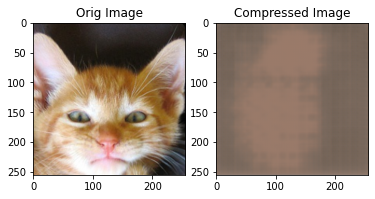

In [0]:
PIC = np.random.choice(20)
print(PIC)
plt.subplot(1,2,1)
plt.imshow(decoder_model.imgs[PIC])
plt.title('Orig Image')

plt.subplot(1,2,2)
plt.imshow(compressed[PIC])
plt.title('Compressed Image')

plt.show()

In [0]:
save_to_git('reduced_size_of_pulls')

Already up to date.
[master 574bf4c] reduced_size_of_pulls
 5 files changed, 236 insertions(+), 23 deletions(-)
 rewrite faces_capstone2/decoder.h5 (76%)
 rewrite faces_capstone2/faces_decoder.ipynb (91%)
 create mode 100644 faces_capstone2/test.csv
 create mode 100644 faces_capstone2/test.h5
 rewrite faces_capstone2/train_log.csv (96%)
Counting objects: 8, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 2.08 MiB | 1.53 MiB/s, done.
Total 8 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:rashmi-raviprasad/springboard.git
   7f8fb14..574bf4c  master -> master


In [0]:
os.chdir(REPOSITORY+'/faces_capstone2')
log = pd.read_csv(LOGS_FN)
log.head()

,Date,Run_Number,Num_Epochs_Tot,Train_Loss,Valid_Loss
0,2020-03-10 02:27:40.443648,0,0,NaN,NaN
1,2020-03-10 02:28:16.455108,1,5,0.031323,0.057537
2,2020-03-10 02:28:58.949584,2,10,0.019592,0.059774
3,2020-03-10 02:29:45.312118,3,15,0.015328,0.060629
4,2020-03-10 02:30:29.528276,4,20,0.013094,0.059538


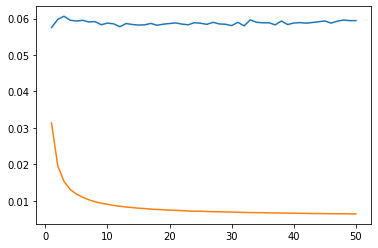

In [0]:
plt.plot(log[['Valid_Loss', 'Train_Loss']])
plt.show()